<a href="https://colab.research.google.com/github/BiancadeFrancisco/Algoritmo_Recomendacao_Movies/blob/main/movie_recommender_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Revisão**

![](https://raw.githubusercontent.com/cmcouto-silva/pictures/main/recommender_systems/non_personalized_recommender.png)

![](https://raw.githubusercontent.com/cmcouto-silva/pictures/main/recommender_systems/recommender_system_diagram.png)

![](https://raw.githubusercontent.com/cmcouto-silva/pictures/main/recommender_systems/ContentBasedFiltering_vs_CollaborativeFiltering.png)

# **Considerações Iniciais**

O conjunto de dados utilizado nesta revisão é proveniente do grupo [MovieLens](https://grouplens.org/datasets/movielens/). Este dataset é uma amostragem simples de um dataset maior (ml-latest.zip), e contém 100.836 avaliações de 9.742, feitas por 610 usuários.

Todas as descrições das variáveis do dataset estão contidas [neste arquivo README](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) disponível do site da MovieLens.

São quatro arquivos, contudo, para esta dinâmica apenas os arquivos `movies.csv` e `ratings.csv` são suficientes.  
O arquivo `tags.csv` poderia contribuir para o sistema de recomendação baseado em conteúdo, mas devido à elevada cardinalidade das tags, que demandaria maior esforço computacional, optei por ignorá-las.

Os principais ToDos deste projeto são:
- Construir um sistema de recomendação baseado em conteúdo (content-based model)
- Construir um sistema de recomendação de filtro colaborativo.

# **SETUP**

## **Libraries**

In [ ]:
import gc
import numpy as np
import pandas as pd
from itertools import permutations

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform

## **Dataset**

Download dataset:

In [ ]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip

--2023-08-05 14:18:38--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  2.64MB/s    in 0.4s    

2023-08-05 14:18:38 (2.64 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


Carregando e manipulando dados dos filmes:

In [ ]:
# Ler dataset
df_movies = pd.read_csv('ml-latest-small/movies.csv')
print(df_movies.shape)
df_movies.head()

(9742, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
# Separar gêneros em uma lista
df_movies['genres'] = df_movies.genres.str.split('|')

# Capturar gêneros únicos
genres = sorted(set(df_movies.genres.explode()))
genres.remove('(no genres listed)')

# Produzir variáveis dummies para os gêneros
for genre in genres:
    df_movies[genre] = df_movies.genres.map(lambda movie_genres: genre in movie_genres).astype(int)

# Capturar o ano de lançamento do filme
df_movies['year'] = df_movies.title.str.strip().str.extract('\(([\d]{4})\)$', expand=False)
df_movies.dropna(subset=['year'], inplace=True) # Excluir NAs (13 filmes)
df_movies['year'] = df_movies.year.astype(int) # convert to int
# Criar nova variável com a década de lançamento
df_movies['decade'] = df_movies.year.sub(df_movies.year%10)
# Excluir NAs (13 filmes)
df_movies.dropna(subset=['year','decade'], inplace=True)
# Excluir filmes com nomes duplicados (5 duplicados)
df_movies = df_movies.drop_duplicates(subset=['title'])

# Visualizando o conjunto final
display(df_movies)

,movieId,title,genres,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,decade
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1995,1990
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1995,1990
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1995,1990
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1995,1990
4,5,Father of the Bride Part II (1995),[Comedy],0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1995,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,2017,2010
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,2017,2010
9739,193585,Flint (2017),[Drama],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2017,2010
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2018,2010


Carregando dados das avaliações:

In [ ]:
# Ler dataset
df_ratings = pd.read_csv('ml-latest-small/ratings.csv')
# Mostrar dataset
display(df_ratings)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


Merge dos dados dos filmes com as avaliações dos usuários:

In [ ]:
df = df_ratings.merge(df_movies, on='movieId').drop(columns='genres')
df

,userId,movieId,rating,timestamp,title,Action,Adventure,Animation,Children,Comedy,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,decade
0,1,1,4.0,964982703,Toy Story (1995),0,1,1,1,1,...,0,0,0,0,0,0,0,0,1995,1990
1,5,1,4.0,847434962,Toy Story (1995),0,1,1,1,1,...,0,0,0,0,0,0,0,0,1995,1990
2,7,1,4.5,1106635946,Toy Story (1995),0,1,1,1,1,...,0,0,0,0,0,0,0,0,1995,1990
3,15,1,2.5,1510577970,Toy Story (1995),0,1,1,1,1,...,0,0,0,0,0,0,0,0,1995,1990
4,17,1,4.5,1305696483,Toy Story (1995),0,1,1,1,1,...,0,0,0,0,0,0,0,0,1995,1990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100807,610,160341,2.5,1479545749,Bloodmoon (1997),1,0,0,0,0,...,0,0,0,0,0,1,0,0,1997,1990
100808,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),1,0,0,0,0,...,0,0,0,0,0,0,0,0,1971,1970
100809,610,160836,3.0,1493844794,Hazard (2005),1,0,0,0,0,...,0,0,0,0,0,1,0,0,2005,2000
100810,610,163937,3.5,1493848789,Blair Witch (2016),0,0,0,0,0,...,0,0,0,0,0,1,0,0,2016,2010


Verificando presença de linhas duplicadas ou valores faltantes:

In [ ]:
df.duplicated().any() | df.isna().any().any()

False

# **EDA**

Verificar a média de avaliação dos filmes e quantas vezes foram avaliados:

In [ ]:
df_rating_summary = df.groupby('title').agg(rating_mean=('rating', 'mean'), rating_count=('rating', 'count')).sort_values('rating_count', ascending=False)
df_rating_summary.describe()

,rating_mean,rating_count
count,9706.000000,9706.000000
mean,3.261776,10.386565
std,0.869176,22.418362
min,0.500000,1.000000
25%,2.800000,1.000000
50%,3.416667,3.000000
75%,3.909091,9.000000
max,5.000000,329.000000


Lista dos filmes com mais avaliações:

In [ ]:
df_rating_summary.sort_values('rating_count', ascending=False).head(20)

,rating_mean,rating_count
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


Lista dos filmes melhor avaliados em média:

In [ ]:
df_rating_summary.sort_values('rating_mean', ascending=False).head(20)

,rating_mean,rating_count
title,,
The Adventures of Sherlock Holmes and Doctor Watson: The Treasures of Agra (1983),5.0,1
61* (2001),5.0,1
A Plasticine Crow (1981),5.0,1
A Detective Story (2003),5.0,1
A Perfect Day (2015),5.0,1
"Act of Killing, The (2012)",5.0,1
9/11 (2002),5.0,1
12 Chairs (1976),5.0,1
12 Angry Men (1997),5.0,1


## Visualizações

Configuração pessoal para plots:

In [ ]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=1,
    rc={
        'figure.figsize':(12,8),
        'axes.grid':True,
        'grid.alpha':.2,
        'axes.labelpad':10,
        'axes.titlepad': 20
    }
)

Visualizando a contagem total das avaliações:

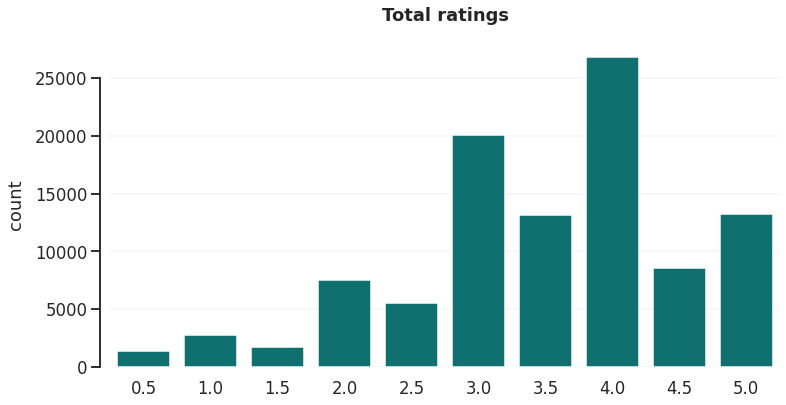

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x=df.rating, color='teal')
plt.title('Total ratings', weight='bold')
plt.tick_params(bottom=False)
plt.xlabel(None)

sns.despine(offset=10, trim=True, bottom=True)
plt.show()

Visualizando a quantidade total filmes por gênero:

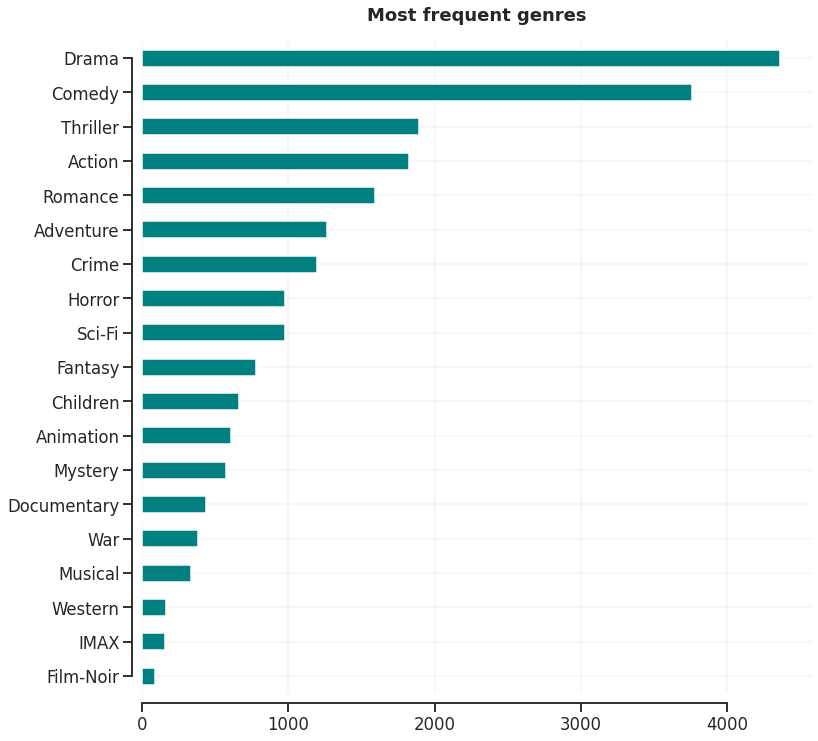

In [ ]:
df_movies.loc[:,'Action':'Western'].sum().sort_values().rename('count').plot.barh(color='teal', figsize=(12,12))
plt.title('Most frequent genres', weight='bold')
sns.despine(offset=10, trim=True)

Verificando a proporção de cada avaliação por gênero:

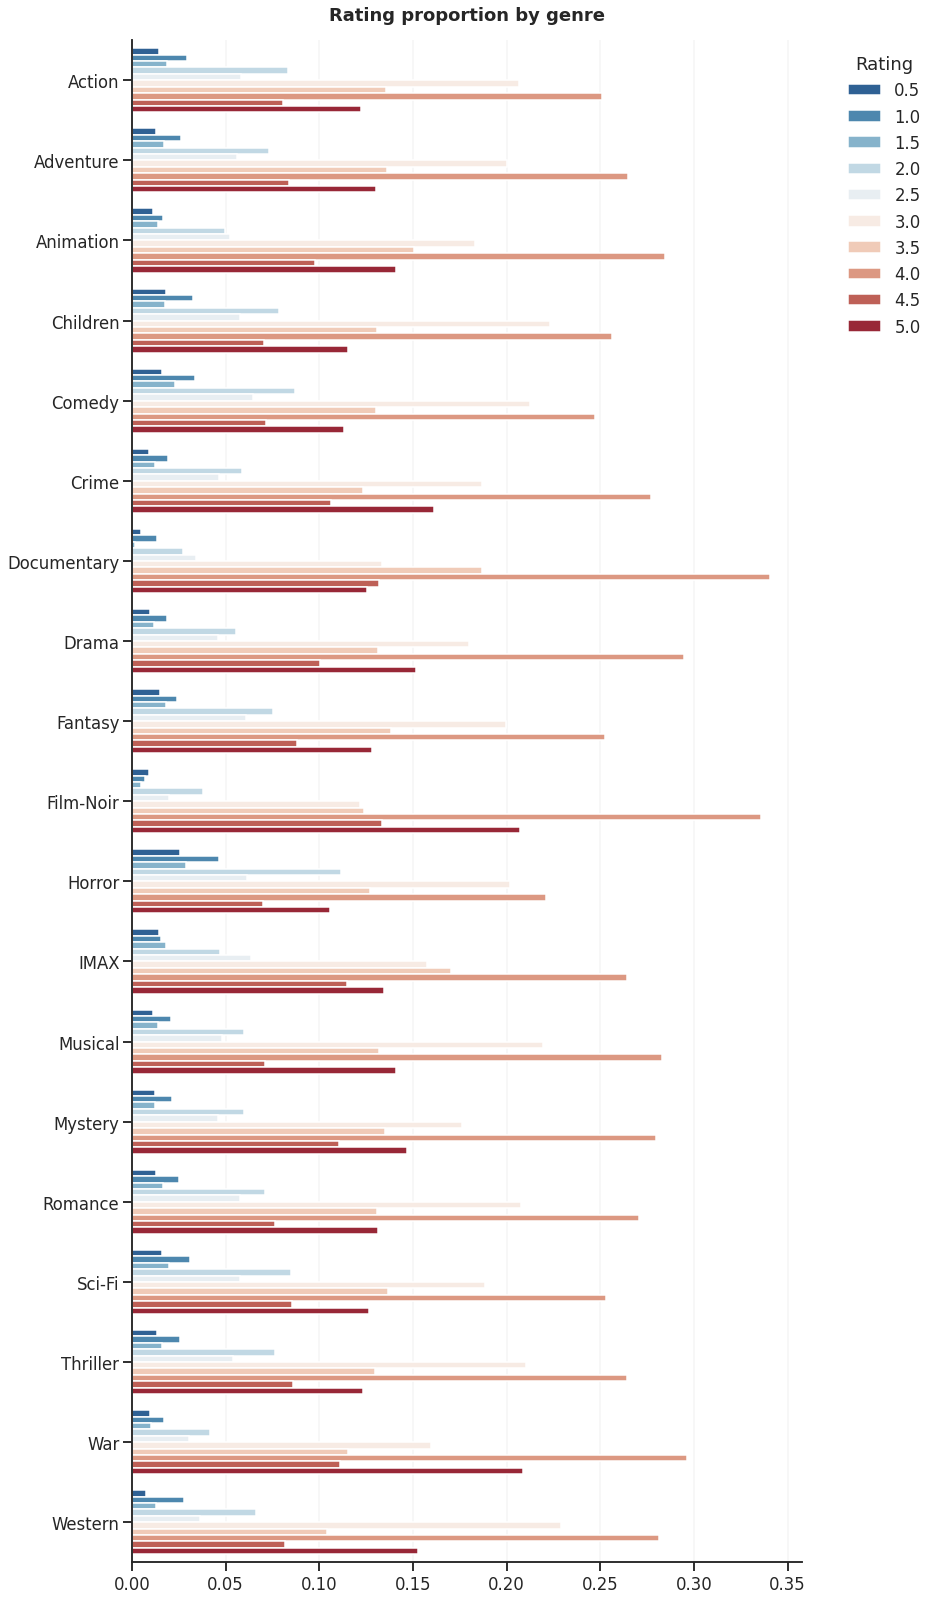

In [ ]:
df_counts = df.loc[:, 'Action':'Western'].assign(rating=df.rating).melt(id_vars='rating', var_name='genre').groupby(['rating','genre']).value.sum().to_frame('count').reset_index()
df_counts['count'] /= df_counts.groupby('genre')['count'].transform('sum')

plt.figure(figsize=(12,28))
ax = sns.barplot(data=df_counts, x='count', y='genre', hue='rating', palette='RdBu_r')
ax.set(xlabel=None, ylabel=None)
plt.title('Rating proportion by genre', weight='bold')
plt.legend(title='Rating', bbox_to_anchor=(1.2, 1), frameon=False)
sns.despine()

Verificando a distribuição dos filmes ao longo dos anos:

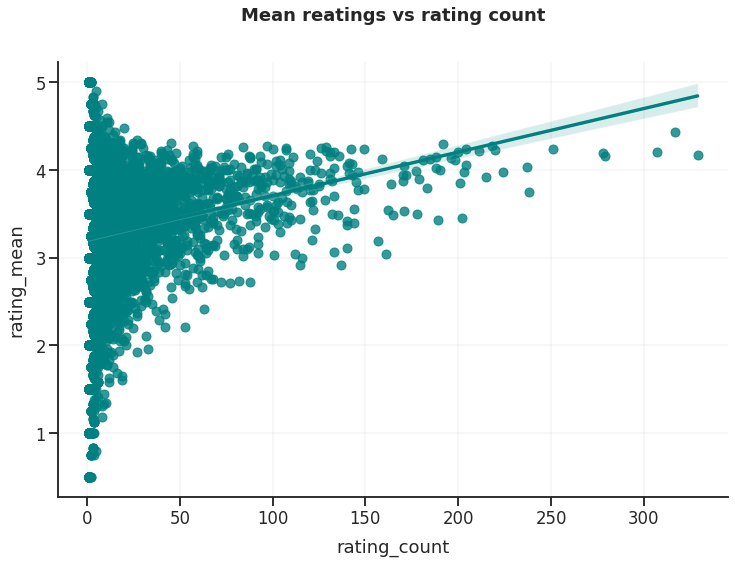

In [ ]:
sns.regplot(data=df_rating_summary, x='rating_count', y='rating_mean', color='teal')
plt.title('Mean reatings vs rating count', weight='bold', y=1.05)
sns.despine()

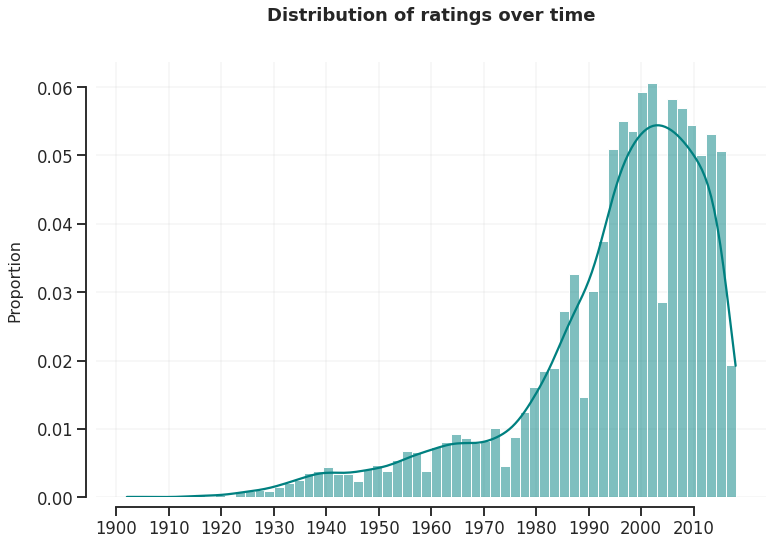

In [ ]:
ax = sns.histplot(df_movies.year, color='teal', alpha=.5, stat='proportion', kde=True)
plt.title('Distribution of ratings over time', weight='bold', y=1.05)
plt.xticks(sorted(df.decade.unique()))
plt.xlabel(None)
plt.ylabel('Proportion', size=16, labelpad=15)
sns.despine(offset=10, trim=True)

## Non-personalized recommendations

## Filmes mais populares

In [ ]:
df.set_index(['userId','movieId']).head()

,,rating,timestamp,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,decade
userId,movieId,,,,,,,,,,,,,,,,,,,,,
1,1,4.0,964982703,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1995,1990
5,1,4.0,847434962,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1995,1990
7,1,4.5,1106635946,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1995,1990
15,1,2.5,1510577970,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1995,1990
17,1,4.5,1305696483,Toy Story (1995),0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,1995,1990


In [ ]:
df.title.value_counts().head(10)

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

## Filmes melhor avaliados

In [ ]:
df.groupby('title').rating.mean().sort_values(ascending=False).head()

title
Saving Santa (2013)                                 5.0
Scooby-Doo! Curse of the Lake Monster (2010)        5.0
Scooby-Doo! Abracadabra-Doo (2010)                  5.0
Garden of Words, The (Koto no ha no niwa) (2013)    5.0
Garfield's Pet Force (2009)                         5.0
Name: rating, dtype: float64

In [ ]:
# Finding the most liked popular items
well_evaluated_items = df.title.value_counts().to_frame().ge(100).query('title').index
df.query('title in @well_evaluated_items').groupby('title').rating.mean().sort_values(ascending=False).head()

title
Shawshank Redemption, The (1994)    4.429022
Godfather, The (1972)               4.289062
Fight Club (1999)                   4.272936
Godfather: Part II, The (1974)      4.259690
Departed, The (2006)                4.252336
Name: rating, dtype: float64

## Filmes comumente assistidos juntos

In [ ]:
def create_pairs(items):
  return permutations(items, 2)

In [ ]:
# Função para criar pares de itens (filmes) assistidos por um mesmo usuário
def create_pairs(items):
    pairs = pd.DataFrame(permutations(items, 2), columns=['movie1','movie2'])
    return pairs

In [ ]:
%%time
# Pegar usuários aleatórios, para não precisar calcular a permutação para todos usuários, pois é computacionalmente demandante
# n_random_users = 100
# random_user_ids = np.random.choice(df_ratings.userId.unique(), n_random_users)

# Adquirir combinações 2-a-2 de filmes por usuário
movie_combinations = (
    df#[df.userId.isin(random_user_ids)]
    .groupby('userId').title
    .apply(create_pairs)
    .reset_index(drop=True)
)

# Calcular quantidade que filmes aparecem juntos e estruturar output
movie_combinations = movie_combinations.groupby(['movie1','movie2']).size().to_frame('count').sort_values('count', ascending=False).reset_index()
# Dataframe das combinações:
display(movie_combinations)

,movie1,movie2,count
0,Forrest Gump (1994),"Shawshank Redemption, The (1994)",231
1,"Shawshank Redemption, The (1994)",Forrest Gump (1994),231
2,Forrest Gump (1994),Pulp Fiction (1994),230
3,Pulp Fiction (1994),Forrest Gump (1994),230
4,Pulp Fiction (1994),"Shawshank Redemption, The (1994)",222
...,...,...,...
26280463,"History Boys, The (2006)",Boys on the Side (1995),1
26280464,"History Boys, The (2006)","Boys of Baraka, The (2005)",1
26280465,"History Boys, The (2006)",Boys Town (1938),1
26280466,"History Boys, The (2006)","Boy and His Dog, A (1975)",1


CPU times: user 56.6 s, sys: 16.2 s, total: 1min 12s
Wall time: 1min 15s


In [ ]:
gc.collect()

3

In [ ]:
movie_combinations

,movie1,movie2,count
0,"Matrix, The (1999)",Fight Club (1999),36
1,Fight Club (1999),"Matrix, The (1999)",36
2,"Matrix, The (1999)","Lord of the Rings: The Fellowship of the Ring,...",34
3,"Lord of the Rings: The Fellowship of the Ring,...","Matrix, The (1999)",34
4,"Sixth Sense, The (1999)","Matrix, The (1999)",34
...,...,...,...
6204493,Gosford Park (2001),Lara Croft: Tomb Raider (2001),1
6204494,Gosford Park (2001),Laputa: Castle in the Sky (Tenkû no shiro Rapy...,1
6204495,Gosford Park (2001),Lake Placid (1999),1
6204496,Gosford Park (2001),Labyrinth (1986),1


In [ ]:
filme_clicado = 'Matrix, The (1999)'
movie_combinations[movie_combinations.movie1.eq(filme_clicado)
]

,movie1,movie2,count
0,"Matrix, The (1999)",Fight Club (1999),36
2,"Matrix, The (1999)","Lord of the Rings: The Fellowship of the Ring,...",34
6,"Matrix, The (1999)","Sixth Sense, The (1999)",34
9,"Matrix, The (1999)",Forrest Gump (1994),33
14,"Matrix, The (1999)","Lord of the Rings: The Two Towers, The (2002)",32
...,...,...,...
1682681,"Matrix, The (1999)",Basic (2003),1
1682682,"Matrix, The (1999)",Barry Lyndon (1975),1
1682683,"Matrix, The (1999)",Barney's Version (2010),1
1682684,"Matrix, The (1999)",Barney's Great Adventure (1998),1


In [ ]:
def get_recommendation_by_watched_together(movie, n=10):
    movie_bool = movie_combinations.movie1.eq(movie)
    if movie_bool.any():
        recommendation_df = movie_combinations[movie_bool].set_index('movie1').head(n)
        return recommendation_df.rename_axis('target_movie').rename(columns={'movie2':'movie_recommendation'})
    else:
        print(f'"{movie}" not found.\nReturning top {n} movies:')
        return df.title.value_counts().head(n)

In [ ]:
# df_movies[df_movies.title.str.lower().str.contains('potter')]#.loc[5166,'title']

In [ ]:
# Filmes frequentemente assistindos com Senhor dos Anéis (2001)
movie = 'Lord of the Rings: The Fellowship of the Ring, The (2001)'
get_recommendation_by_watched_together(movie, n=10)

,movie_recommendation,count
target_movie,,
"Lord of the Rings: The Fellowship of the Ring, The (2001)","Matrix, The (1999)",34
"Lord of the Rings: The Fellowship of the Ring, The (2001)","Lord of the Rings: The Return of the King, The...",34
"Lord of the Rings: The Fellowship of the Ring, The (2001)","Lord of the Rings: The Two Towers, The (2002)",32
"Lord of the Rings: The Fellowship of the Ring, The (2001)",Fight Club (1999),31
"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode IV - A New Hope (1977),27
"Lord of the Rings: The Fellowship of the Ring, The (2001)","Sixth Sense, The (1999)",27
"Lord of the Rings: The Fellowship of the Ring, The (2001)","Silence of the Lambs, The (1991)",26
"Lord of the Rings: The Fellowship of the Ring, The (2001)",Shrek (2001),26
"Lord of the Rings: The Fellowship of the Ring, The (2001)",Forrest Gump (1994),26


In [ ]:
get_recommendation_by_watched_together('nao_existe', n=10)

"nao_existe" not found.
Returning top 10 movies:


Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

# **Content-based approach**

Criar input para o sistema de recomendação por conteúdo:

In [ ]:
df_movies_dummies = pd.get_dummies(df_movies.set_index('movieId').loc[:,[*genres,'decade']], columns=['decade'])
df_movies_dummies

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,decade_1920,decade_1930,decade_1940,decade_1950,decade_1960,decade_1970,decade_1980,decade_1990,decade_2000,decade_2010
movieId,,,,,,,,,,,,,,,,,,,,,
1,0,1,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
193583,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
193585,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


Calcular distância utilizando a métrica de jaccard:

In [ ]:
# Calculando distâncias para todos os filmes
jaccard_distances = pdist(df_movies_dummies.values, metric='jaccard')
# Reshape para matriz
square_jaccard_distances = 1 - squareform(jaccard_distances)
# Convertendo para dataframe para visualização
square_jaccard_distances_df = pd.DataFrame(square_jaccard_distances, index=df_movies.title, columns=df_movies.title)
# Visualização da matriz de similaridade pela métrica jaccard
display(square_jaccard_distances_df)

title,Toy Story (1995),Jumanji (1995),Grumpier Old Men (1995),Waiting to Exhale (1995),Father of the Bride Part II (1995),Heat (1995),Sabrina (1995),Tom and Huck (1995),Sudden Death (1995),GoldenEye (1995),...,Gintama: The Movie (2010),anohana: The Flower We Saw That Day - The Movie (2013),Silver Spoon (2014),Love Live! The School Idol Movie (2015),Jon Stewart Has Left the Building (2015),Black Butler: Book of the Atlantic (2017),No Game No Life: Zero (2017),Flint (2017),Bungo Stray Dogs: Dead Apple (2018),Andrew Dice Clay: Dice Rules (1991)
title,,,,,,,,,,,,,,,,,,,,,
Toy Story (1995),1.000000,0.666667,0.285714,0.250000,0.333333,0.111111,0.285714,0.500000,0.142857,0.250000,...,0.222222,0.125000,0.125000,0.142857,0.000000,0.375000,0.428571,0.000000,0.125,0.333333
Jumanji (1995),0.666667,1.000000,0.166667,0.142857,0.200000,0.142857,0.166667,0.750000,0.200000,0.333333,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.142857,0.000000,0.000,0.200000
Grumpier Old Men (1995),0.285714,0.166667,1.000000,0.750000,0.666667,0.166667,1.000000,0.200000,0.250000,0.166667,...,0.142857,0.000000,0.200000,0.000000,0.000000,0.142857,0.166667,0.000000,0.000,0.666667
Waiting to Exhale (1995),0.250000,0.142857,0.750000,1.000000,0.500000,0.142857,0.750000,0.166667,0.200000,0.142857,...,0.125000,0.166667,0.400000,0.000000,0.000000,0.125000,0.142857,0.200000,0.000,0.500000
Father of the Bride Part II (1995),0.333333,0.200000,0.666667,0.500000,1.000000,0.200000,0.666667,0.250000,0.333333,0.200000,...,0.166667,0.000000,0.250000,0.000000,0.000000,0.166667,0.200000,0.000000,0.000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Black Butler: Book of the Atlantic (2017),0.375000,0.125000,0.142857,0.125000,0.166667,0.125000,0.142857,0.000000,0.166667,0.125000,...,0.666667,0.333333,0.333333,0.400000,0.166667,1.000000,0.800000,0.166667,0.600,0.166667
No Game No Life: Zero (2017),0.428571,0.142857,0.166667,0.142857,0.200000,0.000000,0.166667,0.000000,0.000000,0.000000,...,0.500000,0.400000,0.400000,0.500000,0.200000,0.800000,1.000000,0.200000,0.400,0.200000
Flint (2017),0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.166667,0.666667,0.666667,0.333333,0.333333,0.166667,0.200000,1.000000,0.250,0.000000


Recomendando um filme:

In [ ]:
def contentbased_recommender(movie, n=10):
    try:
        return square_jaccard_distances_df.loc[movie].drop(movie).sort_values(ascending=False)[:n+1].to_frame('similarity')
        # df_recommender.index = pd.MultiIndex.from_tuples([(movie,x) for x in df_recommender.index])
        # return df_recommender.rename_axis(['target_movie','recommendation'])
    except:
        print(f'"{movie}" not found.\nReturning top {n} movies:')
        return df.title.value_counts().head(n)

In [ ]:
contentbased_recommender('Toy Story (1995)')

,similarity
title,
Antz (1998),1.000000
Toy Story 2 (1999),1.000000
Space Jam (1996),0.857143
The Love Bug (1997),0.833333
Asterix & Obelix vs. Caesar (Astérix et Obélix contre César) (1999),0.833333
We're Back! A Dinosaur's Story (1993),0.833333
"Borrowers, The (1997)",0.833333
Asterix in America (a.k.a Asterix Conquers America) (Astérix et les Indiens) (1994),0.833333
Kirikou and the Sorceress (Kirikou et la sorcière) (1998),0.833333


In [ ]:
contentbased_recommender('Lord of the Rings: The Fellowship of the Ring, The (2001)')

,similarity
title,
Dinotopia (2002),1.00
"Lord of the Rings: The Two Towers, The (2002)",1.00
Harry Potter and the Chamber of Secrets (2002),1.00
Fire and Ice (2008),1.00
Inkheart (2008),1.00
"10th Kingdom, The (2000)",0.75
Highlander: Endgame (Highlander IV) (2000),0.75
"Librarian: Return to King Solomon's Mines, The (2006)",0.75
Earthsea (Legend of Earthsea) (2004),0.75


Aqui provavelmente as tags ajudariam, mas como a cardinalidade é alta, aumentaria consideravelmente o custo computacional.

# **Collaborative filtering**

Para o filtro colaborativo precisamos de um dataframe pivoteado:

In [ ]:
df_ratings_pivot = df.pivot(index='title', columns='userId', values='rating')
df_ratings_pivot

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.5,NaN,NaN
xXx (2002),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,2.0
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5


Como há muitos valores faltantes (o que é esperado, pois não esperamos que cada usuário avalie todos os filmes), imputados 0 no valor faltante, pois excluir NAs nestes modelos significa perder todo ou praticamente todo o dataset. Contudo, imputar e deixar 0 como está também não é a melhor alternativa, pois 0 significaria uma avaliação de desgosto, e que não é necessariamente o caso, pois pode e costuma-se haver filmes não vistos pelo usuário que ele gostaria. Para corrigir isso, podemos centralizra as avaliações em 0 subtraindo a média das avaliações de cada filme:

In [ ]:
avg_ratings = df_ratings_pivot.mean(axis=0)
df_ratings_pivot_normed = df_ratings_pivot.sub(avg_ratings, axis=1).fillna(0)

In [ ]:
df_ratings_pivot_normed

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.311444
'Hellboy': The Seeds of Creation (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Round Midnight (1986),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Salem's Lot (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Til There Was You (1997),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,1.492047,0.0,0.0,0.0,0.0,1.365824,0.0,0.000000
xXx (2002),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.26087,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.365824,0.0,-1.688556
xXx: State of the Union (2005),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-2.188556


In [ ]:
# Calculando matriz de similaridade
similarity_matrix_df = pd.DataFrame(cosine_similarity(df_ratings_pivot_normed), index=df_ratings_pivot_normed.index, columns=df_ratings_pivot_normed.index)
# Mostrando matriz de similaridade como dataframe
display(similarity_matrix_df)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.029816,0.000000,...,0.000000,0.136691,-0.190954,-0.714730,0.0,0.000000,-0.303421,-0.618923,0.000000,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,1.000000,-0.234086,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Round Midnight (1986),0.000000,-0.234086,1.000000,0.000000,0.000000,0.0,0.092156,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Salem's Lot (2004),0.000000,0.000000,0.000000,1.000000,0.861417,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Til There Was You (1997),0.000000,0.000000,0.000000,0.861417,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.004518,-0.144652,-0.120632,-0.025995,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.082617,0.000000,-0.128194,0.0
xXx (2002),-0.303421,0.000000,0.000000,0.000000,0.000000,0.0,0.052988,0.000000,-0.010867,0.110345,...,0.332041,-0.367691,0.140556,0.301544,0.0,0.082617,1.000000,0.477631,-0.011086,0.0
xXx: State of the Union (2005),-0.618923,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.040265,0.000000,...,0.000000,-0.485752,0.118186,0.442363,0.0,0.000000,0.477631,1.000000,0.000000,0.0


In [ ]:
def collaborativefiltering_recommender(movie, n=10):
    try:
        return similarity_matrix_df.loc[movie].drop(movie).sort_values(ascending=False)[:n+1].to_frame('similarity')
    except:
        print(f'"{movie}" not found.\nReturning top {n} movies:')
        return df.title.value_counts().head(n)

In [ ]:
collaborativefiltering_recommender('Toy Story (1995)')

,similarity
title,
Toy Story 2 (1999),0.403423
Toy Story 3 (2010),0.327467
Aladdin (1992),0.327145
Wallace & Gromit: The Wrong Trousers (1993),0.305392
Back to the Future (1985),0.276691
"Incredibles, The (2004)",0.274969
Blazing Saddles (1974),0.271617
Finding Nemo (2003),0.263823
Ghostbusters (a.k.a. Ghost Busters) (1984),0.249641


In [ ]:
collaborativefiltering_recommender('Lord of the Rings: The Fellowship of the Ring, The (2001)')

,similarity
title,
"Lord of the Rings: The Two Towers, The (2002)",0.767316
"Lord of the Rings: The Return of the King, The (2003)",0.714479
Spirited Away (Sen to Chihiro no kamikakushi) (2001),0.313240
Zodiac (2007),0.298945
Indiana Jones and the Last Crusade (1989),0.293869
Memento (2000),0.292247
Star Wars: Episode V - The Empire Strikes Back (1980),0.288863
Star Wars: Episode IV - A New Hope (1977),0.285249
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),0.279774


In [ ]:
collaborativefiltering_recommender('filme_nao_existente')

"filme_nao_existente" not found.
Returning top 10 movies:


Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

O que poderíamos fazer para melhorar o sistema de recomendação por filtro colaborativo seria excluir filmes com poucas avaliações (vimos que tem bastante na EDA). Outra coisa interessante seria compilar estes códigos em classes, lidando com todos os possíves erros de valores e argumentos.

## General Class

In [ ]:
class ItemBasedRecommender:

  def __init__(self, data, item_col, user_col, score_col, aggfunc=np.mean):
    self.data = data.copy()
    self.item_col = item_col
    self.user_col = user_col
    self.score_col = score_col
    self.aggfunc = aggfunc

  def fit(self, sample_size=None, normalize=True, n_most_popular=10):

    if sample_size is not None:
      self.item_sample_ = self.data.groupby(self.item_col)[self.user_col] \
        .nunique() \
        .sort_values(ascending=False) \
        .to_frame('nunique_customers') \
        .head(sample_size) \
        .index.tolist()
      self.data = self.data[self.data[self.item_col].isin(self.item_sample_)]

    self.scores_ = self.data.groupby(self.item_col).agg(**{
        f'{self.score_col}_{self.aggfunc.__name__}': (self.score_col, self.aggfunc),
        f'{self.score_col}_count': ('rating', 'count')
        }).sort_values(f'{self.score_col}_count', ascending=False)

    self.n_most_popular_ = self.data[self.item_col].value_counts().nlargest(n_most_popular).index

    self.data_pivot_ = self.data.pivot(index=self.item_col, columns=self.user_col, values=self.score_col)
    if normalize:
      avg_ratings = self.data_pivot_.mean(axis=0)
      self.data_pivot_ = self.data_pivot_.sub(avg_ratings, axis=1).fillna(0)
    else:
      self.data_pivot_ = self.data_pivot_.fillna(0)

    self.sim_matrix_ = cosine_similarity(self.data_pivot_)
    self.sim_matrix_ = pd.DataFrame(self.sim_matrix_, index=self.data_pivot_.index, columns=self.data_pivot_.index)
    return self

  def recommend(self, target_item, max_recommendations=None):
    try:
      return self.sim_matrix_.loc[target_item].drop(target_item).sort_values(ascending=False).head(max_recommendations)
    except KeyError as e:
      print(f'\033[1m{target_item}\033[0;0m is not included in the recommendation matrix. Returning top 10 items:\n')
      return self.n_most_popular_

  def fit_recommend(self, target_item):
    return self.fit().recommend(target_item)

In [ ]:
recommender = ItemBasedRecommender(df, item_col='title', user_col='userId', score_col='rating')

In [ ]:
print('Coluna que identifica os itens:', recommender.item_col)
print('Coluna que identifica os usuários:', recommender.user_col)
print('Coluna que identifica as avaliações:', recommender.score_col)

Coluna que identifica os itens: title
Coluna que identifica os usuários: userId
Coluna que identifica as avaliações: rating


In [ ]:
recommender.fit()

In [ ]:
recommender.data_pivot_

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.311444
'Hellboy': The Seeds of Creation (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Round Midnight (1986),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Salem's Lot (2004),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
'Til There Was You (1997),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,1.492047,0.0,0.0,0.0,0.0,1.365824,0.0,0.000000
xXx (2002),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.26087,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.365824,0.0,-1.688556
xXx: State of the Union (2005),0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,-2.188556


In [ ]:
recommender.sim_matrix_

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.029816,0.000000,...,0.000000,0.136691,-0.190954,-0.714730,0.0,0.000000,-0.303421,-0.618923,0.000000,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,1.000000,-0.234086,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Round Midnight (1986),0.000000,-0.234086,1.000000,0.000000,0.000000,0.0,0.092156,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Salem's Lot (2004),0.000000,0.000000,0.000000,1.000000,0.861417,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
'Til There Was You (1997),0.000000,0.000000,0.000000,0.861417,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.004518,-0.144652,-0.120632,-0.025995,...,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.082617,0.000000,-0.128194,0.0
xXx (2002),-0.303421,0.000000,0.000000,0.000000,0.000000,0.0,0.052988,0.000000,-0.010867,0.110345,...,0.332041,-0.367691,0.140556,0.301544,0.0,0.082617,1.000000,0.477631,-0.011086,0.0
xXx: State of the Union (2005),-0.618923,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-0.040265,0.000000,...,0.000000,-0.485752,0.118186,0.442363,0.0,0.000000,0.477631,1.000000,0.000000,0.0


In [ ]:
recommender.n_most_popular_

Index(['Forrest Gump (1994)', 'Shawshank Redemption, The (1994)',
       'Pulp Fiction (1994)', 'Silence of the Lambs, The (1991)',
       'Matrix, The (1999)', 'Star Wars: Episode IV - A New Hope (1977)',
       'Jurassic Park (1993)', 'Braveheart (1995)',
       'Terminator 2: Judgment Day (1991)', 'Schindler's List (1993)'],
      dtype='object')

In [ ]:
recommender.scores_

,rating_mean,rating_count
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
...,...,...
King Solomon's Mines (1937),2.500000,1
King Ralph (1991),1.500000,1
King Kong Lives (1986),2.000000,1


## Exemplos

In [ ]:
movie = 'Toy Story (1995)'
recommender.recommend(movie, 10)

title
Toy Story 2 (1999)                                                                0.403423
Toy Story 3 (2010)                                                                0.327467
Aladdin (1992)                                                                    0.327145
Wallace & Gromit: The Wrong Trousers (1993)                                       0.305392
Back to the Future (1985)                                                         0.276691
Incredibles, The (2004)                                                           0.274969
Blazing Saddles (1974)                                                            0.271617
Finding Nemo (2003)                                                               0.263823
Ghostbusters (a.k.a. Ghost Busters) (1984)                                        0.249641
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    0.236960
Name: Toy Story (1995), dtype: float64

In [ ]:
movie = 'Lord of the Rings: The Fellowship of the Ring, The (2001)'
recommender.recommend(movie, 10)

title
Lord of the Rings: The Two Towers, The (2002)                                     0.767316
Lord of the Rings: The Return of the King, The (2003)                             0.714479
Spirited Away (Sen to Chihiro no kamikakushi) (2001)                              0.313240
Zodiac (2007)                                                                     0.298945
Indiana Jones and the Last Crusade (1989)                                         0.293869
Memento (2000)                                                                    0.292247
Star Wars: Episode V - The Empire Strikes Back (1980)                             0.288863
Star Wars: Episode IV - A New Hope (1977)                                         0.285249
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    0.279774
Winter's Bone (2010)                                                              0.277691
Name: Lord of the Rings: The Fellowship of the Ring, The (2001), dtype: float64

In [ ]:
df_movies[df_movies.title.str.lower().str.contains('potter')].sort_values('year').iloc[0].title

"Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"

In [ ]:
movie = "Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)"
recommender.fit_recommend(movie).head(15)

title
Harry Potter and the Chamber of Secrets (2002)                            0.581807
Harry Potter and the Prisoner of Azkaban (2004)                           0.516070
Harry Potter and the Half-Blood Prince (2009)                             0.451029
Harry Potter and the Goblet of Fire (2005)                                0.450923
Harry Potter and the Deathly Hallows: Part 1 (2010)                       0.445751
Harry Potter and the Deathly Hallows: Part 2 (2011)                       0.423534
Harry Potter and the Order of the Phoenix (2007)                          0.407643
The Hunger Games: Catching Fire (2013)                                    0.376446
Waitress (2007)                                                           0.331941
Who Killed the Electric Car? (2006)                                       0.315599
Iron Man 2 (2010)                                                         0.310555
Chronicles of Narnia: The Lion, the Witch and the Wardrobe, The (2005)    0.31052

# Material Suplementar

**Leitura**

---

- [Practical recommender systems](https://livebook.manning.com/book/practical-recommender-systems/about-this-book/)
- [Methods of recommender system: A review](https://ieeexplore.ieee.org/document/8275856)
- [Web Recommender System for Job Seeking and Recruiting](https://www.researchgate.net/publication/323726564_Web_Recommender_System_for_Job_Seeking_and_Recruiting)

**Bibliotecas**

---

- [Surprise](https://surpriselib.com/) is a Python library for "building and analyzing recommender systems" that seems reasonably popular and up-to-date.